Import packages

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-11-20 12:03:10.025881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732082590.085980   52719 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732082590.103338   52719 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 12:03:10.228398: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Aquire dataset

In [2]:
import pathlib

dataset_url = "https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip"
# Get the zip file from the URL and extract it
data_dir = tf.keras.utils.get_file('pizza_steak.zip', cache_dir="./", origin=dataset_url, extract=True)
# remove the file suffix
data_dir = pathlib.Path(data_dir).with_suffix('')
data_dir = data_dir / "pizza_steak"

Check downloaded dataset

In [4]:
image_count = len(list(data_dir.glob('**/*.jpg')))
print(image_count)

2000


Import dataset

In [5]:
test_dir = data_dir / "test"
train_dir = data_dir / "train"

In [6]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [30]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, 
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=101,
)

Found 500 files belonging to 2 classes.


In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, 
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=101,
)

Found 1500 files belonging to 2 classes.


Inspect dataset

In [9]:
train_ds.class_names

['pizza', 'steak']

In [10]:
class_names = train_ds.class_names
num_classes = len(class_names)

Split test dataset for validation and testing

In [31]:
test_cardinality = tf.data.experimental.cardinality(test_ds)
val_ds = test_ds.skip(test_cardinality // 5)
test_ds = test_ds.take(test_cardinality // 5)

Cache dataset for performance

In [32]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create lower layers

Data augmentation layers

In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
])

Global average pooling

In [14]:
global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D()

Dropout

In [15]:
dropout = tf.keras.layers.Dropout(0.2)

Pre-trained model inputs

In [16]:
process_input = tf.keras.applications.mobilenet_v3.preprocess_input

Rescale

In [17]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## Define training function

In [40]:
from sklearn.metrics import classification_report
import seaborn as sns

def train_model(base_model: tf.keras.Model, initial_epochs=10, fine_epochs=10, learning_rate=0.0001):
  # First, freeze the pre-trained model
  base_model.trainable = False

  # Define the custom model using functional api
  inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
  y = data_augmentation(inputs)
  y = process_input(y)
  y = base_model(y, training=False)
  y = global_avg_pooling(y)
  y = dropout(y)
  outputs = tf.keras.layers.Dense(num_classes)(y)

  model = tf.keras.Model(inputs, outputs)
  # Compile the model for the first step
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=['accuracy'],
  )
  
  # Early stopping
  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=0,
  )


  # Fit the model without modifying the weights
  history = model.fit(
      train_ds,
      epochs=initial_epochs,
      validation_data=val_ds,
      callbacks=[early_stopping],
  )

  # Unfreeze the base model
  base_model.trainable = True

  # Fine-tune from this layer onwards
  fine_tune_at = 100

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  # Compile the model again with unfreezed top layers
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate/10),
      metrics=['accuracy'],
  )

  # Fine-tune the model
  history_fine = model.fit(
      train_ds,
      epochs=initial_epochs+fine_epochs,
      initial_epoch=len(history.epoch),
      validation_data=val_ds,
      callbacks=[early_stopping],
  )

  # Plot the results
  initial_epochs = len(history.epoch)
  fine_epochs = len(history_fine.epoch)
  epochs = initial_epochs + fine_epochs

  acc = history.history['accuracy'] + history_fine.history['accuracy']
  val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

  loss = history.history['loss'] + history_fine.history['loss']
  val_loss = history.history['val_loss'] + history_fine.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(18, 8))

  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

  # Retrieve a batch of images from the test set
  image_batch, label_batch = test_ds.as_numpy_iterator().next()
  predictions = model.predict_on_batch(image_batch)

  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[np.argmax(predictions[i])])
    plt.axis("off")

  loss, accuracy = model.evaluate(test_ds)
  print('Test accuracy :', accuracy)
  
  # Generate predictions
  y_pred = model.predict(test_ds)  # Model predictions
  y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
  y_true = np.array([labels for _, labels in test_ds]).flatten()  # True labels

  # Generate Classification Report
  report = classification_report(y_true, y_pred_classes, target_names=class_names)
  print("Classification Report:")
  print(report)

  # Generate Confusion Matrix
  cm = tf.math.confusion_matrix(y_true, y_pred_classes)
  print("Confusion Matrix:")
  print(cm)

  # Optionally, visualize the confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,
              yticklabels=class_names)
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.title('Confusion Matrix')
  plt.show()

  return model

Train the model with aquired dataset

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.6598 - loss: 0.6924 - val_accuracy: 0.8639 - val_loss: 0.3741
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7590 - loss: 0.5113 - val_accuracy: 0.9282 - val_loss: 0.2464
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8116 - loss: 0.4271 - val_accuracy: 0.9554 - val_loss: 0.1786
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8382 - loss: 0.3598 - val_accuracy: 0.9703 - val_loss: 0.1355
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8531 - loss: 0.3189 - val_accuracy: 0.9777 - val_loss: 0.1095
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9079 - loss: 0.2665 - val_accuracy: 0.9827 - val_loss: 0.0913
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9045 - loss: 0.2387 - val_accuracy: 0.9827 - val_loss: 0.0785
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9130 - loss: 0.2314 - val_accuracy: 0.9827 - v

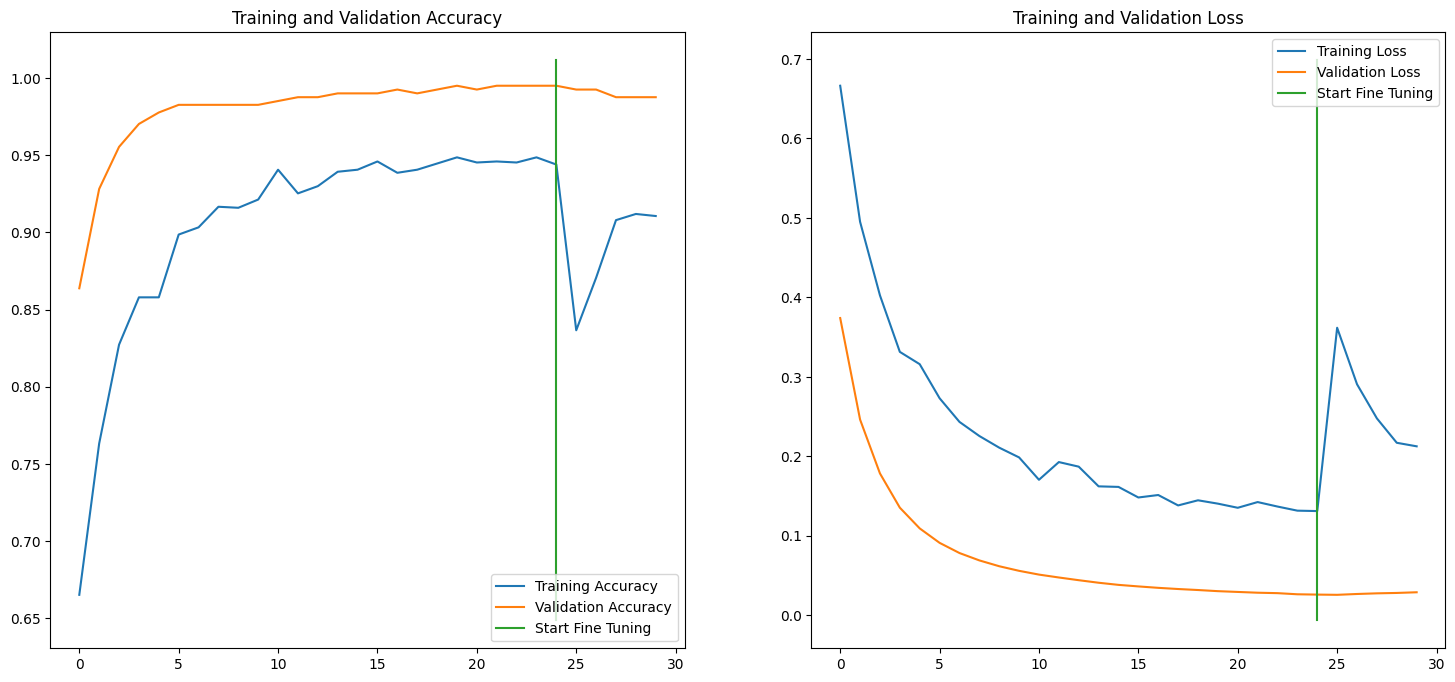

2024-11-20 12:35:10.344256: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9948 - loss: 0.0227
Test accuracy : 0.9895833134651184
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Classification Report:
              precision    recall  f1-score   support

       pizza       0.98      1.00      0.99        45
       steak       1.00      0.98      0.99        51

    accuracy                           0.99        96
   macro avg       0.99      0.99      0.99        96
weighted avg       0.99      0.99      0.99        96

Confusion Matrix:
tf.Tensor(
[[45  0]
 [ 1 50]], shape=(2, 2), dtype=int32)


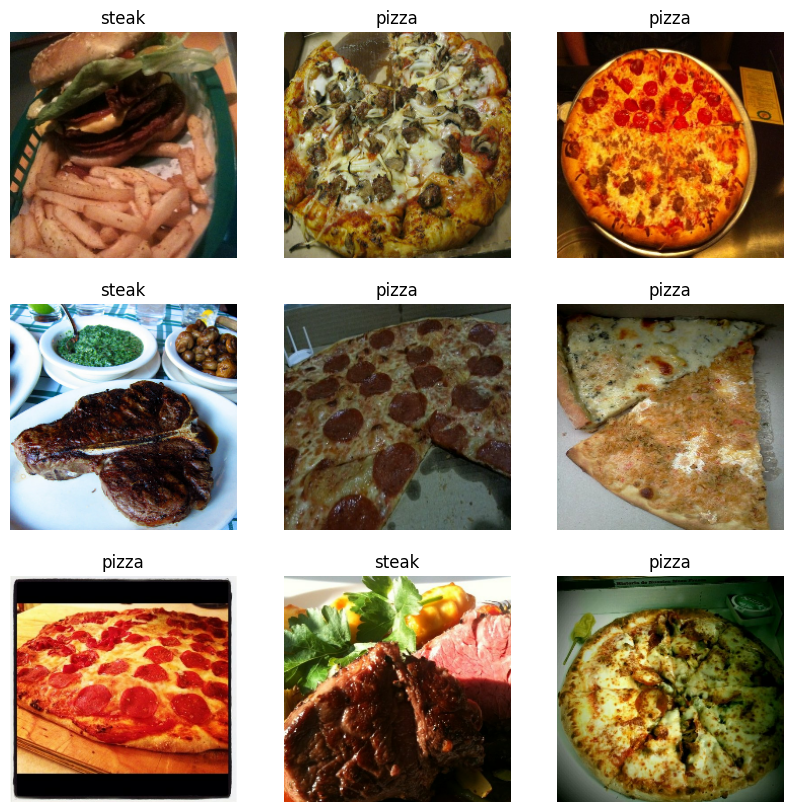

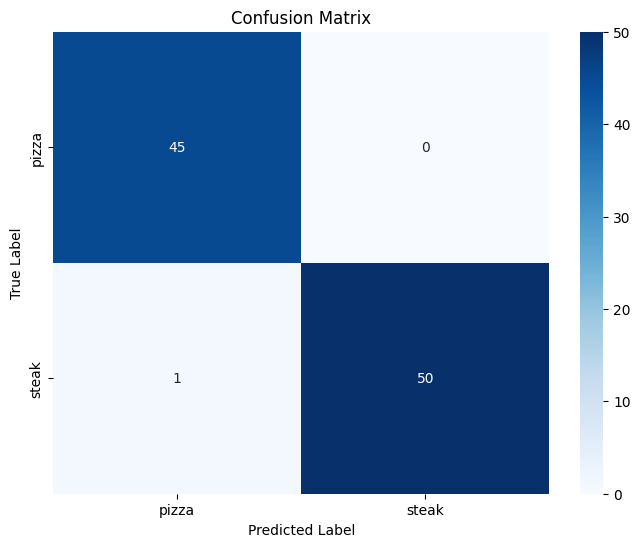

In [41]:
# Re-import the MobileNetV3Large again for fine-tuning
base_model_3 = tf.keras.applications.MobileNetV3Large(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet',
)

model_3 = train_model(base_model=base_model_3, initial_epochs=50, fine_epochs=50)

In [56]:
model_3.save('models/pizza_steak.keras')

In [57]:
model_x = tf.keras.models.load_model('models/pizza_steak.keras')
model_x.name

# import tensorflowjs as tfjs
# tfjs.converters.save_keras_model(model_x, './models/pizza_steak_js')

'functional_6'

In [58]:
model_x.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         1,922 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,812,198 (22.17 MB)

 Trainable params: 2,813,922 (10.73 MB)

 Non-trainable params: 184,352 (720.12 KB)

 Optimizer params: 2,813,924 (10.73 MB)

In [59]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model_x, './models/pizza_steak_js')

TypeError: cannot pickle 'module' object